In [1]:
import os
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

In [2]:
MES_DATADIR = '../../original/master_dataset/'
files = listdir(MES_DATADIR)
if '.DS_Store' in files:
    files.remove('.DS_Store')
print("Number of measurement files in datadir: {}".format(len(files)))
i = 0
for file in files:
    print("idx:", i," ",file)
    i+=1
def get_mes_list():
    files = listdir(MES_DATADIR)
    #files.remove('.DS_Store')
    return MES_DATADIR, files

Number of measurement files in datadir: 29
idx: 0   Mittaus_16,00Hz_5300mm_-20mm.lvm
idx: 1   Mittaus_17,00Hz_5300mm_0mm.lvm
idx: 2   Mittaus_15,00Hz_5300mm_0mm.lvm
idx: 3   Mittaus_13,00Hz_5300mm_0mm.lvm
idx: 4   Mittaus_14,00Hz_5300mm_-20mm.lvm
idx: 5   Mittaus_13,00Hz_5300mm_-100mm.lvm
idx: 6   Mittaus_8,00Hz_5300mm_-20mm.lvm
idx: 7   Mittaus_11,00Hz_5300mm_0mm.lvm
idx: 8   Mittaus_12,00Hz_5300mm_-20mm.lvm
idx: 9   Mittaus_6,00Hz_5300mm_-20mm.lvm
idx: 10   Mittaus_18,00Hz_5300mm_0mm.lvm
idx: 11   Mittaus_4,00Hz_5300mm_-20mm.lvm
idx: 12   Mittaus_10,00Hz_5300mm_-20mm.lvm
idx: 13   Mittaus_14,00Hz_5300mm_-10mm.lvm
idx: 14   Mittaus_17,00Hz_5300mm_-20mm.lvm
idx: 15   Mittaus_9,00Hz_5300mm_0mm.lvm
idx: 16   Mittaus_11,00Hz_5300mm_-150mm.lvm
idx: 17   Mittaus_9,00Hz_5300mm_-300mm.lvm
idx: 18   Mittaus_8,00Hz_5300mm_-10mm.lvm
idx: 19   Mittaus_16,00Hz_5300mm_-10mm.lvm
idx: 20   Mittaus_7,00Hz_5300mm_-300mm.lvm
idx: 21   Mittaus_15,00Hz_5300mm_-60mm.lvm
idx: 22   Mittaus_10,00Hz_5300mm_-10

In [3]:
def read_file():
    idx = int(input("Give idx of the file you want to study:"))
    MES_DATADIR, files = get_mes_list()
    print(files[idx])
    f = open(os.path.join(MES_DATADIR,files[idx]),'r')
    

    #Removing metadata
    fl = f.readline()
    while '***End_of_Header***'not in fl:
        fl = f.readline()

    fl = f.readline()
    while '***End_of_Header***'not in fl:
        fl = f.readline()

    #Extracting data
    Header = f.readline().split('\t')
    fl = f.read()
    dataframe = pd.read_csv(io.StringIO(fl), sep='\t',engine = 'python',names = Header)
    freqs = dataframe[['Untitled']].copy()
    avg_freq = np.round(np.mean(freqs.apply(lambda x: x.str.replace(',','.')).values[1:20].astype('float64')),6)
    print(avg_freq)

    signals = dataframe[['laser s1','laser s2','laser s3','laser s4']].copy()
    #accelerations = dataframe[['kiihtyvyys x1', 'kiihtyvyys y1', 'kiihtyvyys x2', 'kiihtyvyys y2']].copy()
    forces = dataframe[['voima x1', 'voima y1', 'voima y2', 'voima x2', 'voima y3','voima y4']]

    signals = signals.apply(lambda x: x.str.replace(',','.')).values.astype('float64')
    #accelerations = accelerations.apply(lambda x: x.str.replace(',','.')).values.astype('float64')
    forces = forces.apply(lambda x: x.str.replace(',','.')).values.astype('float64')

    f.close()
    return(signals,forces,avg_freq,files[idx])

(signals,forces, avg_freq,file) = read_file()
#original_accelerations = np.copy(accelerations)
original_forces = np.copy(forces)

Give idx of the file you want to study:0
Mittaus_16,00Hz_5300mm_-20mm.lvm
15.896958


No handles with labels found to put in legend.


(102400, 4)


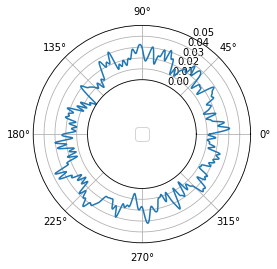

In [4]:
from fourpoint import *
p_per_r = 1024
rounds = 100
start = 0
stop = start+p_per_r
starts = [1024*i for i in range(rounds)]
for start, round_ in zip(starts,range(rounds)):
    stop = start+1024
    print(signals.shape)
    s1 = signals[start:stop,0]
    s2 = signals[start:stop,1]
    s3 = signals[start:stop,2]
    s4 = signals[start:stop,3]
    hybrid = hybrid_f_coeff(signals[start:stop,:].T,angles = [0, 36.91, 66.45])
    filtered_hybrid = filter_fft(hybrid)
    h = get_roundness_profile(filtered_hybrid)
    polar_plot(data = h,offset = 0.05)
    break


In [5]:
from fourpoint import * 
def signal_to_cpm(signals):
    #print(signals.shape)#102400,4
    signals = signals.T #Transpose
    hybrid_array = np.zeros((2,signals.shape[1])) #2,102400
    #print(hybrid_array.shape)
    SAMPLES_IN_ROUND = 1024
    
    for round_ in range(100):
        start = round_*SAMPLES_IN_ROUND
        stop = start+SAMPLES_IN_ROUND
        round_signals = signals[:,start:stop]#4,1024
        #print(round_signals.shape)
        hybrid = hybrid_f_coeff(round_signals, angles=[0, 36.91, 66.45])
        #print(hybrid.shape)
        filtered_hybrid = filter_fft(hybrid)
        #print(filtered_hybrid.shape)
        s = [round_signals[0], round_signals[2]]
        #print(s[0].shape)
        angles = [0, 66.45]
        
        hybrid_cpm = get_cpm(s, angles, filtered_hybrid)
        #print(hybrid_cpm.shape)
        hybrid_array[0,start:stop] = hybrid_cpm[0,:]
        hybrid_array[1,start:stop] = hybrid_cpm[1,:]
        
    return hybrid_array
    

In [6]:
cpm_arr = signal_to_cpm(signals)
print("With x = 0, and y = 1")
print(cpm_arr.shape)
original_cpm_arr = np.copy(cpm_arr)

With x = 0, and y = 1
(2, 102400)


Give the starting round to be plotted.0
Give the number of rounds to be plotted:5
0.0
0.06290511681543098
0.12581023363086197
0.18871535044629292
0.25162046726172393
0.3145255840771549
0.0
0.06290511681543098
0.12581023363086197
0.18871535044629292
0.25162046726172393
0.3145255840771549


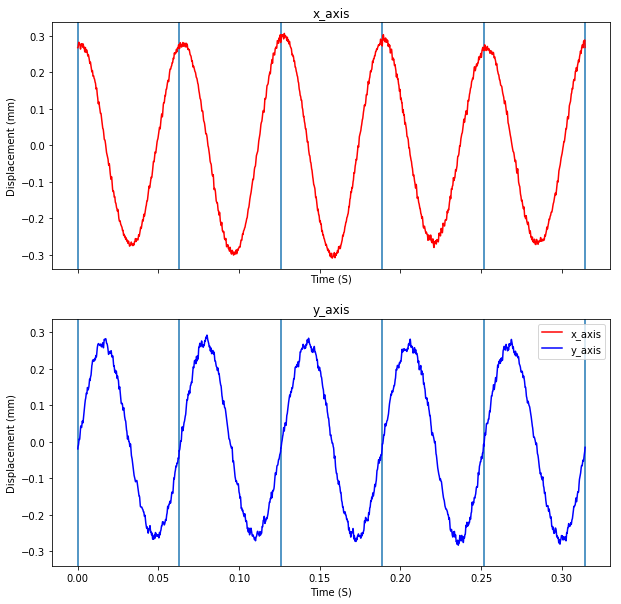

In [7]:
cpm_labels = ['x_axis','y_axis']
def plot_cpm_subseq(cpm_arr,rot_frq):

    fig, axes = plt.subplots(2, sharex = True, sharey = True, figsize = (10,10))

    start = int(input("Give the starting round to be plotted."))
    start = start*1024
    windowlen = int(input("Give the number of rounds to be plotted:"))
    windowlen = windowlen*1024

    rounds = [x*1024/rot_frq/1024 for x in range(int(start/1024),int(start/1024)+int(windowlen/1024)+1,1)]

    timesteps = np.linspace(start/rot_frq/1024,(start+windowlen)/rot_frq/1024,windowlen)
    for i in range(2):
        axes[i].set_xlabel('Time (S)')
        axes[i].set_ylabel('Displacement (mm)')
        axes[i].title.set_text(cpm_labels[i])
        for round_ in rounds:
            axes[i].axvline(x = round_)
            print(round_)
        
    l1, = axes[0].plot(timesteps,cpm_arr[start:start+windowlen,0], label = cpm_labels[0], color= 'red')
    l2, = axes[1].plot(timesteps,cpm_arr[start:start+windowlen,1], label = cpm_labels[1], color= 'blue')

    plt.legend(handles = [l1,l2])
    
    plt.show(fig)

plot_cpm_subseq(cpm_arr.T,avg_freq)

(102400,)
Mittaus_16,00Hz_5300mm_-20mm.lvm


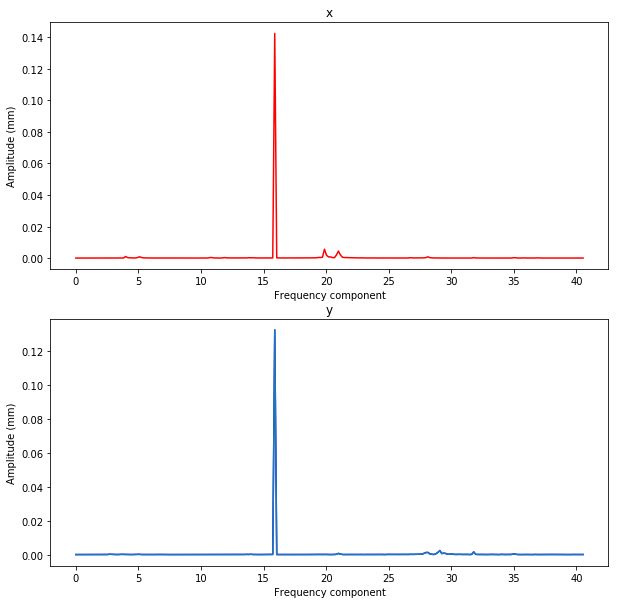

In [8]:
def plot_displacement_f_domain(original_cpm_arr ,file):

    print(file)
    

    labels = ['x','y']
    colors = ['red','blue']
    fig, ax = plt.subplots(2,figsize = (10,10))
    #print(original_cpm_arr.shape)
    for i in range(2):
        
        y = original_cpm_arr[i,:]
        n = len(y)
        k = np.arange(n)
        T = n/int(1024*avg_freq)
        frq = k/T #two sides frequency range

        frq = frq[range(int(n/400))] #one side frequency range
        Y = np.fft.fft(y)/n #fft computing and normalisation
        Y = Y[range(int(n/400))]
        ax[i].plot(frq,np.abs(Y),color = colors[i] )
        ax[i].title.set_text(labels[i])
        ax[i].set_xlabel('Frequency component')
        ax[i].set_ylabel('Amplitude (mm)')
    plt.plot(frq,np.abs(Y))
    plt.show()
    
    #plot()
    
print(original_cpm_arr[1].shape)
plot_displacement_f_domain(original_cpm_arr,file)


In [9]:
def normalise_arr(arr1d):
    arr1d_min = np.min(arr1d)
    arr1d_max = np.max(arr1d)
    arr1d = 2 * (arr1d - arr1d_min) / (arr1d_max - arr1d_min) - 1
    return arr1d, (arr1d_min,arr1d_max)

In [10]:
from scipy.signal import resample
def resample_arr(cpm_array,forces, avg_freq):
    samples_in_round = 1024
    n_samples = 102400
    rounds = n_samples / samples_in_round
    time = rounds / avg_freq
    new_len = int(time*2000)
    cpm_array = cpm_array.T
    
    x = resample(cpm_array[:,0],new_len).reshape(new_len,1)
    y = resample(cpm_array[:,1],new_len).reshape(new_len,1)
    
    forcex1 = resample(forces[:,0],new_len).reshape(new_len,1)
    forcey1 = resample(forces[:,1],new_len).reshape(new_len,1)
    forcey2 = resample(forces[:,2],new_len).reshape(new_len,1)
    forcex2 = resample(forces[:,3],new_len).reshape(new_len,1)
    forcey3 = resample(forces[:,4],new_len).reshape(new_len,1)
    forcey4 = resample(forces[:,5],new_len).reshape(new_len,1)

    cpm = np.concatenate((x,y,forcex1,forcey1,forcey2,forcex2,forcey3,forcey4,),axis = 1)
    return cpm

In [11]:
from scipy.signal import resample
def resample_normalise_arr(cpm_array,forces, avg_freq):
    samples_in_round = 1024
    n_samples = 102400
    rounds = n_samples / samples_in_round
    time = rounds / avg_freq
    new_len = int(time*2000)
    cpm_array = cpm_array.T
   
    x = resample(cpm_array[:,0],new_len).reshape(new_len,1)
    x, (xmin,xmax) = normalise_arr(x)
    x = x.reshape(new_len,1)
    
    y = resample(cpm_array[:,1],new_len).reshape(new_len,1)
    y, (ymin,ymax) = normalise_arr(y)
    y = y.reshape(new_len,1)
    
    forcex1 = resample(forces[:,0],new_len).reshape(new_len,1)
    forcex1, (fx1min,fx1max) = normalise_arr(forcex1)
    forcex1 = forcex1.reshape(new_len,1)
    
    forcey1 = resample(forces[:,1],new_len).reshape(new_len,1)
    forcey1, (fy1min,fy1max) = normalise_arr(forcey1)
    forcey1 = forcey1.reshape(new_len,1)
    
    forcey2 = resample(forces[:,2],new_len).reshape(new_len,1)
    forcey2, (fy2min,fy2max) = normalise_arr(forcey2)
    forcey2 = forcey2.reshape(new_len,1)
    
    forcex2 = resample(forces[:,3],new_len).reshape(new_len,1)
    forcex2, (fx2min,fx2max) = normalise_arr(forcex2)
    forcex2 = forcex2.reshape(new_len,1)
    
    forcey3 = resample(forces[:,4],new_len).reshape(new_len,1)
    forcey3, (fy3min,fy3max) = normalise_arr(forcey3)
    forcey3 = forcey3.reshape(new_len,1)
    
    forcey4 = resample(forces[:,5],new_len).reshape(new_len,1)
    forcey4, (fy4min,fy4max) = normalise_arr(forcey4)
    forcey4 = forcey4.reshape(new_len,1)
    
    minsmaxes = {'x':(xmin,xmax),
                 'y':(ymin,ymax),
                 'forcex1':(fx1min,fx1max),
                 'forcey1':(fy1min,fy1max),
                 'forcey2':(fy2min,fy2max),
                 'forcex2':(fx2min,fx2max),
                 'forcey3':(fy3min,fy3max),
                 'forcey4':(fy4min,fy4max)}
    resampled_signals = np.concatenate((x,y,forcex1,forcey1,forcey2,forcex2,forcey3,forcey4),axis = 1)
    return resampled_signals,minsmaxes

In [12]:
#cpm_n_accs = resample_arr(cpm_arr,forces, avg_freq)
cpm_n_accs,minsmaxes = resample_normalise_arr(cpm_arr,forces, avg_freq)

(12581, 8)
Give the starting index for the data:0
Give the number of datapointss to plot:6000
0
1


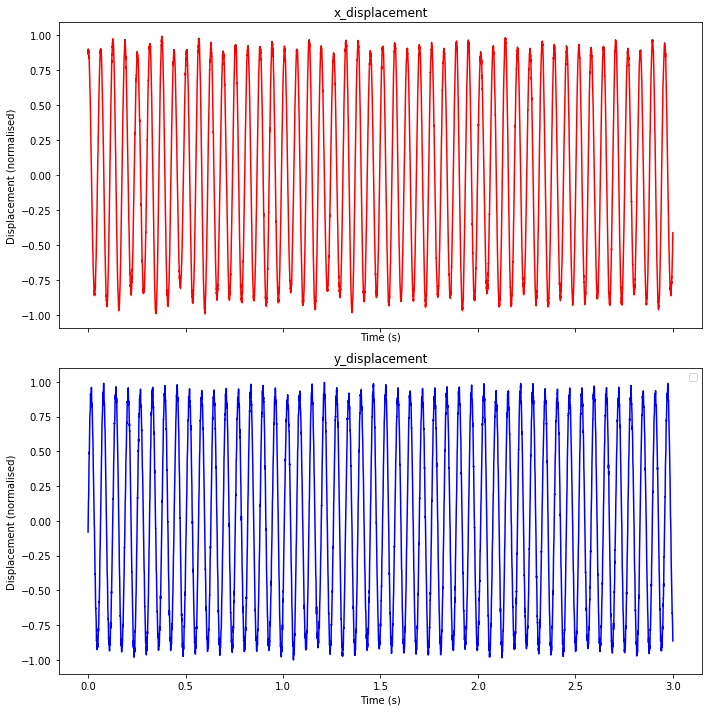

In [13]:
resampled_labels = ['kiihtyvyys x1', 'kiihtyvyys y1', 'kiihtyvyys x2', 'kiihtyvyys y2','x_displacement','y_displacement',
                   'Force x1', 'Force y1', 'Force y2', 'voima x2', 'voima y3', 'voima y4']

def plot_resampled_normalised_CPM(cpm_n_accs):
    
    fig, axes = plt.subplots(2, sharex = True, figsize = (10,10))

    start = int(input("Give the starting index for the data:"))
    windowlen = int(input("Give the number of datapointss to plot:"))
    timesteps = np.linspace(start,start+windowlen,windowlen)/2000
    
    for i in range(0,2,1):
        print(i)
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Displacement (normalised)')
        axes[i].title.set_text(resampled_labels[i+4])
        
    l7, = axes[0].plot(timesteps,cpm_n_accs[start:start+windowlen,0], color = 'red')
    l8, = axes[1].plot(timesteps,cpm_n_accs[start:start+windowlen,1], color = 'blue')

    plt.legend(handles = [l7,l8])
    plt.tight_layout()
    plt.show(fig)

print(cpm_n_accs.shape)
plot_resampled_normalised_CPM(cpm_n_accs)  

Give the starting index for the data:0
Give the number of datapointss to plot:6000


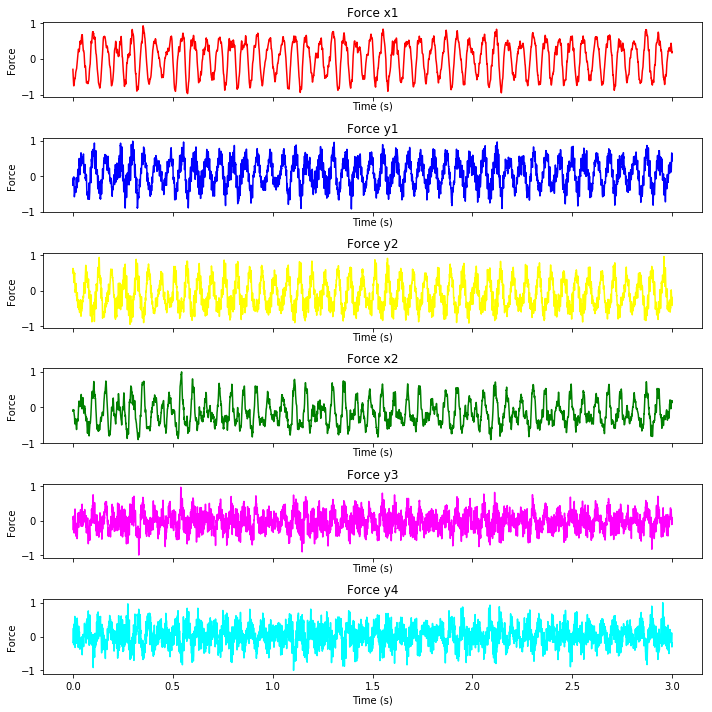

In [14]:

resampled_labels = ['kiihtyvyys x1', 'kiihtyvyys y1', 'kiihtyvyys x2', 'kiihtyvyys y2','x_displacement','y_displacement',
                   'Force x1', 'Force y1', 'Force y2', 'Force x2', 'Force y3', 'Force y4']

def plot_resampled_subseq(cpm_n_accs):

    fig, axes = plt.subplots(6, sharex = True, figsize = (10,10))

    start = int(input("Give the starting index for the data:"))
    windowlen = int(input("Give the number of datapointss to plot:"))
    timesteps = np.linspace(start,start+windowlen,windowlen)/2000

    for i in range(0,6,1):
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Force')
        axes[i].title.set_text(resampled_labels[i+6])

    l7, = axes[0].plot(timesteps,cpm_n_accs[start:start+windowlen,2], color = 'red')
    l8, = axes[1].plot(timesteps,cpm_n_accs[start:start+windowlen,3], color = 'blue')
    l9, = axes[2].plot(timesteps,cpm_n_accs[start:start+windowlen,4], color = 'yellow')
    l10, = axes[3].plot(timesteps,cpm_n_accs[start:start+windowlen,5], color = 'green')
    l11, = axes[4].plot(timesteps,cpm_n_accs[start:start+windowlen,6], color = 'magenta')
    l12, = axes[5].plot(timesteps,cpm_n_accs[start:start+windowlen,7], color = 'cyan')

   # plt.legend(handles = [l7,l8,l9,l10,l11,l12])
    #plt.legend(handles = [l7,l8,l9])

    #fig.suptitle("A")
    plt.tight_layout()
    plt.show(fig)

plot_resampled_subseq(cpm_n_accs)

In [15]:
def read_file_autom(filepath):
    f = open(filepath,'r')

    #Removing metadata
    fl = f.readline()
    while '***End_of_Header***'not in fl:
        fl = f.readline()

    fl = f.readline()
    while '***End_of_Header***'not in fl:
        fl = f.readline()

    #Extracting data
    Header = f.readline().split('\t')
    fl = f.read()
    dataframe = pd.read_csv(io.StringIO(fl), sep='\t',engine = 'python',names = Header)
    freqs = dataframe[['Untitled']].copy()
    avg_freq = np.round(np.mean(freqs.apply(lambda x: x.str.replace(',','.')).values[1:20].astype('float64')),6)

    signals = dataframe[['laser s1','laser s2','laser s3','laser s4']].copy()
    #accelerations = dataframe[['kiihtyvyys x1', 'kiihtyvyys y1', 'kiihtyvyys x2', 'kiihtyvyys y2']].copy()
    forces = dataframe[['voima x1', 'voima y1', 'voima y2', 'voima x2', 'voima y3','voima y4']]

    signals = signals.apply(lambda x: x.str.replace(',','.')).values.astype('float64')
    #accelerations = accelerations.apply(lambda x: x.str.replace(',','.')).values.astype('float64')
    forces = forces.apply(lambda x: x.str.replace(',','.')).values.astype('float64')

    f.close()
    return signals,forces,avg_freq

In [16]:
def new_name(file,avg_freq, minsmaxes):
    filename = file.strip('.lvm')
    filename = filename +'_x_'+str(minsmaxes['x'])+'_y_'+str(minsmaxes['y'])+'_'+str(round(avg_freq,5))+'Hz'

    
    return filename

In [17]:
import pickle
mesdir, files = get_mes_list()
savefolder = '../../original/processed_data/'
minmaxfolder = '../../original/minmaxdata/'
hack_idx = 0
print_every = 50
for file in files:
    filepath = os.path.join(mesdir,file)
    (signals,forces,avg_freq) = read_file_autom(filepath)
    cpm_arr = signal_to_cpm(signals)
    resampled_signals, minsmaxes = resample_normalise_arr(cpm_arr,forces,avg_freq)
    #plot_resampled_normalised_CPM(resampled_signals)
    savepath = savefolder+new_name(file,avg_freq,minsmaxes)+'.csv'
    with open(os.path.join(minmaxfolder,file), 'wb') as fp:
    #with open('data.p', 'wb') as fp:
        pickle.dump(minsmaxes, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pd.DataFrame(resampled_signals).to_csv(savepath)
    if (hack_idx % print_every) == (print_every-1):
        print(hack_idx)